# Bose Hubbard model via Skolem Tridiagonalization 

In [2]:
import os

threads = 1
os.environ['NUMEXPR_MAX_THREADS'] = '{}'.format(threads)
os.environ['NUMEXPR_NUM_THREADS'] = '{}'.format(threads)
os.environ['OMP_NUM_THREADS'] = '{}'.format(threads)
os.environ['MKL_NUM_THREADS'] = '{}'.format(threads)

In [189]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.linalg import eigh_tridiagonal, norm, hankel
from scipy.sparse import block_diag

# from tqdm.notebook import tqdm, trange
import time

from skolem_util import skolem, tuple_from_skolem

#from quspin.operators import hamiltonian # Hamiltonians and operators
#from quspin.basis import boson_basis_1d # Hilbert space boson basis

## Number theoretical tools: The Skolem polynomials and its inverse

## Parameters of the 3 sites Bose Hubbard model and propagation

In [244]:
U = 1
J = 1
mu = 0

# number of bosons
N = 5

# time-step for propagation 
Δt = 0.01

# times to save wavefunctions
times = Δt * np.arange(100)


K = 3


## Using the Skolem for building the propagator  the Bose Hubbard model 

In [252]:
t0 = time.time()

# the cut off of Skolem index
S_min = skolem((K - 1) * [0] + [N])
S_max = skolem([N] + (K - 1) * [0])

skolem_indx = np.arange(S_min, S_max + 1)

# This ordering is to be compartible with QuSpin,
# for example, in the case of K = 3,
#    n3, n2, n1 = n
# In other words, n[0] is the last n in QuSpin
n = np.array(
    [tuple_from_skolem(S, K) for S in skolem_indx]
).T
n = n[::-1]

########################################################
# Reindexing to implement the permutation matrix 
# to bring the neighboring site to tridiagonal form.
########################################################

indx = np.array([
    skolem(_) for _ in n[np.roll(np.arange(K), -1)].T
])
indx -= S_min



In [253]:
# the cut off of Skolem index
S_min = skolem([0, 0, N])
S_max = skolem([N, 0, 0])

skolem_321 = np.arange(S_min, S_max + 1)

# This ordering is to be compartible with QuSpin
n3, n2, n1 = np.array(
    [tuple_from_skolem(S, 3) for S in skolem_321]
).T

## Reindex (n3, n2, n1) <-> (n1, n2, n3)
indx_old = np.array([
    skolem(_) for _ in zip(n1, n2, n3)
]) - S_min

In [281]:
np.roll(np.arange(K), -1)

array([1, 2, 3, 0])

In [243]:
np.roll(np.arange(K), -K + 1)

array([2, 0, 1])

In [271]:
K = 4
q = np.arange(K)
q

array([0, 1, 2, 3])

In [282]:
c = np.roll(np.arange(K),-1)


In [284]:
q[c][c]

array([2, 3, 0, 1])

In [286]:
K - 1

3

In [280]:
np.roll(np.roll(np.roll(q, -1), 1), -2)

array([2, 3, 0, 1])

### Get $\exp(-i\Delta t \hat{H}_{23})$ via block tridiagonalization

In [247]:
# diagonal of the full tri-diagonal Hamiltonian H23
d = 0.25 * U * n2 * (n2 - 1) - 0.5 * mu * n2 + 0.5 * U * n3 * (n3 - 1) - mu * n3

# off diagonal of the full tri-diagonal Hamiltonian H23
e = -J * np.sqrt((n2 + 1) * n3)[1:]

start_block = 0

# Find the edges of the blocks. They are found when the off-diagonals have zeros   
block_edges = np.where(e == 0)[0] + 1

if block_edges[-1] != d.size:
    block_edges = np.append(block_edges, [d.size])

expH_23 = []

# Find matrix exponential via diagonalization of each block separately
for end_block in block_edges:
    block_E_23, block_v = eigh_tridiagonal(
        d[start_block:end_block],
        e[start_block:end_block - 1],
    )
    
    expH_23.append(
        (block_v * np.exp(-1j * Δt * block_E_23)) @ block_v.T
    )

    start_block = end_block
    
# Save as a sparse matrix
expH_23 = block_diag(expH_23)

# Save time it took to initialize the Skolem propagator 
time_prepare_skolem = time.time() - t0

## QuSpin

Comparing the implementation of the Bose-Hubbard Model in the QuSpin library by following: https://github.com/weinbe58/QuSpin/blob/master/examples/notebooks/BHM.ipynb

In [248]:
##### construct Bose-Hubbard Hamiltonian #####
# define boson basis with N states per site L bosons in the lattice
L = 3
basis = boson_basis_1d(3, Nb=N) # full boson basis

# define site-coupling lists
#hop=[[-J,i,(i+1)%L] for i in range(L)] #PBC
hop=[[-J,i,(i+1)%L] for i in range(L - 1)] # open boundary condition
interact=[[0.5*U,i,i] for i in range(L)] # U/2 \sum_j n_j n_j
pot=[[-mu-0.5*U,i] for i in range(L)] # -(\mu + U/2) \sum_j j_n

# define static and dynamic lists
static=[['+-',hop],['-+',hop],['n',pot],['nn',interact]]
dynamic=[]

# build Hamiltonian
H=hamiltonian(static,dynamic,basis=basis,dtype=np.float64)

# print(n1, n2, n3)

NameError: name 'boson_basis_1d' is not defined

### Initial condition

In [8]:
ψ0 = np.zeros(len(basis.states), complex)
ψ0[0] = 1

### QuSpin evolution

In [9]:
t0 = time.time()

Ψ_quspin = H.evolve(ψ0, times[0], times)

print("QuSpin run time {:.1f} s".format(time.time() - t0))

QuSpin run time 5.3 s


### Skolem evolution

In [10]:
t0 = time.time()

Ψ_skolem = [ψ0,]

for _ in times[1:]:
    ψ = expH_23 @ Ψ_skolem[-1][indx]
    ψ = expH_23 @ ψ[indx]
    Ψ_skolem.append(ψ)
    
Ψ_skolem = np.array(Ψ_skolem).T

print("Skolem method run time {:.1f} s".format(time_prepare_skolem + time.time() - t0))

Skolem method run time 1.1 s


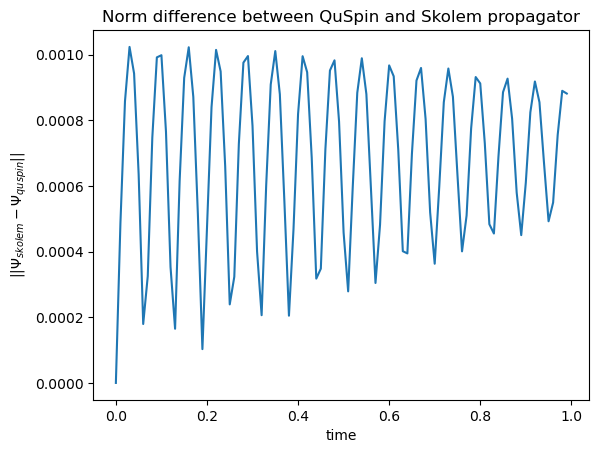

In [11]:
plt.title("Norm difference between QuSpin and Skolem propagator")
plt.plot(times, norm(Ψ_skolem - Ψ_quspin, axis=0))
plt.xlabel("time")
plt.ylabel(r"$\|\|\Psi_{skolem} - \Psi_{quspin}\|\|$")
plt.show()